# Traffic Camera: Detection and tracking


## Imports

We will start by importing a few libraries:

In [1]:
import matplotlib.pyplot as plt
from detectionprovider import DetectionProvider
from tracklet import Tracklet, BoundingBox, create_tracklets, update_tracklets, random_color
from video import VideoStreamReader, VideoStreamWriter
from yolo import YOLO
from tqdm import tqdm

Using TensorFlow backend.


## Download 4K Traffic Cam Video

You will need **youtube-dl** to download the video. (You can ignore this step but still, you will need a video

In [2]:
!youtube-dl -f 313 MNn9qKG2UFI

[youtube] MNn9qKG2UFI: Downloading webpage
[youtube] MNn9qKG2UFI: Downloading video info webpage
[download] 4K Traffic camera video - free download now!-MNn9qKG2UFI.webm has already been downloaded

[download] 100% of 659.43MiB


## View first frame

We will use OpenCV and Matplotlib to view the very first frame:

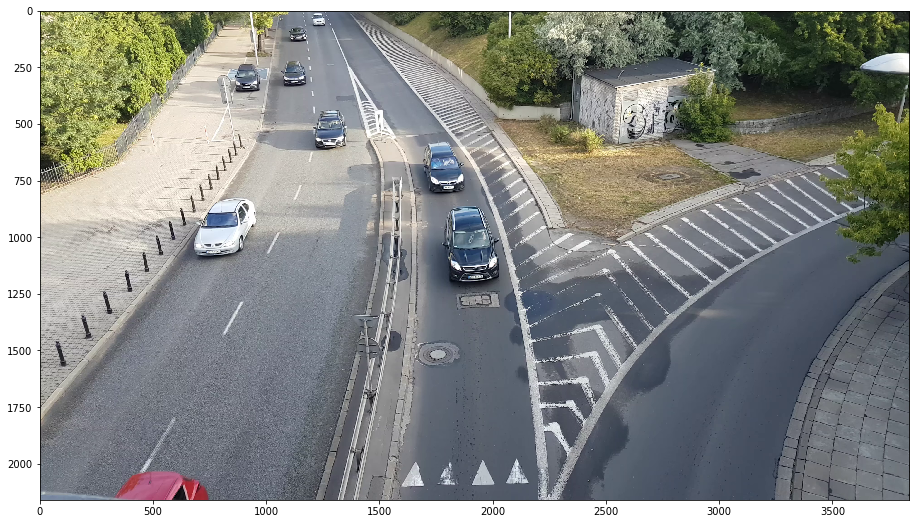

In [3]:
filename = "4K Traffic camera video - free download now!-MNn9qKG2UFI.webm"
downscale = 1

reader = VideoStreamReader(filename, 1, downscale=downscale)
frame = reader.next_frame()
reader.release()
plt.figure(figsize=(16,9))
plt.imshow(frame)
plt.show()

# Prepare YOLO network and generate initial bounding boxes for tracklets

In [4]:
yolo = YOLO()

model_data/yolo.h5 model, anchors, and classes loaded.


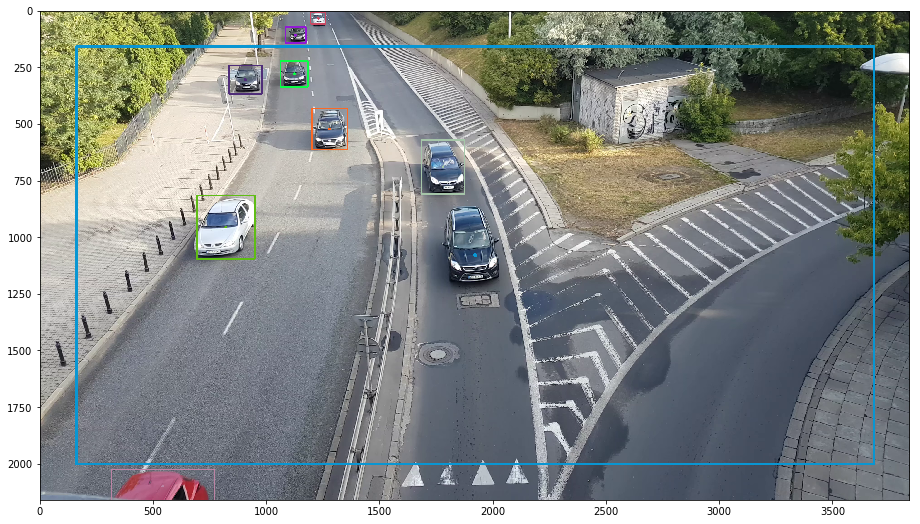

In [5]:
# params
detection_provider = DetectionProvider(yolo, min_confidence=0.8,inflate=2)
boxes = detection_provider.detect_boxes(frame, 0)

frame_copy = frame.copy()
for box in boxes:
    box.show(frame_copy, random_color(),width=5)

# draw area from which we will detect vehicles
padding = 160
detection_bbox = BoundingBox.from_frame(frame, padding)
detection_bbox.show(frame_copy, random_color() ,width=10)
    
plt.figure(figsize=(16,9))
plt.imshow(frame_copy)
plt.show()

# Load frames and propagate through them

In [6]:
filename = "D:/kam_2.mp4"
output_filename = "output_test2.avi"
downscale = 1
padding = 80
seconds_skip = 0 # number of seconds to skip
seconds_count = 10 # number of seconds to process

reader = VideoStreamReader(filename, seconds_count=seconds_count, seconds_skip=seconds_skip,downscale=downscale)
writer = VideoStreamWriter(output_filename, width=reader.width,height=reader.height,fps=reader.fps)

yolo_update = 0.5 # detection update in seconds
fps_update = int(yolo_update * reader.fps)
detection_provider = DetectionProvider(yolo, min_confidence=0.6,inflate=3)

old_tracklets, new_tracklets = [], []
pbar = tqdm(total=reader.frame_count - reader.frame_skip)
frame = reader.next_frame()
while frame is not None:
    pbar.update()
    # detection step
    if reader.frame_no % fps_update == 0:
        detections = detection_provider.detect_boxes(frame, reader.frame_no)
        frame_bbox = BoundingBox.from_frame(frame, padding // downscale)
        # detect only inside frame_bbox region
        # could be multiple regions suitable for detecting objects
        detected_boxes = [x for x in detections if  x.is_inside(frame_bbox)]
        old_tracklets += new_tracklets
        new_tracklets = create_tracklets(frame, detected_boxes) 

    # propagation step
    update_tracklets(old_tracklets, frame, reader.frame_no)  
    update_tracklets(new_tracklets, frame, reader.frame_no)

    # find boxes with high iou indicating that detectors may track the same item
    pairs = []
    for i, old_tracklet in enumerate(old_tracklets):
        for j, new_tracklet in enumerate(new_tracklets):
            if old_tracklet.last_box().iou(new_tracklet.last_box()) > 0.3:
                new_tracklet.merge(old_tracklet)
                pairs.append( (i, j) )

    # removing old
    for i in sorted(list(set([x[0] for x in pairs])),reverse=True):
        old_tracklets.pop(i)

    # checking for exiting bboxes if their center is outside 
    old_ids = [ i for i, old_tracklet in enumerate(old_tracklets) if not old_tracklet.last_box().is_center_inside(frame_bbox)]

    for i in sorted(old_ids,reverse=True):
        old_tracklets.pop(i)

    new_ids = [ i for i, new_tracklet in enumerate(new_tracklets) if not new_tracklet.last_box().is_center_inside(frame_bbox)]
    for i in sorted(new_ids,reverse=True):
        new_tracklets.pop(i)

    for old_tracklet in old_tracklets:
        old_tracklet.show_history(frame)

    for new_tracklet in new_tracklets:
        new_tracklet.show_history(frame)

    writer.write(frame)
    frame = reader.next_frame()
    
pbar.close()
reader.release()
writer.release()

191it [00:47,  2.82it/s]                                                                                               
